In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline
import math

In [4]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.56MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.82MB/s]


In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
from pathlib import Path

output_path = "ytTable:/" + str(Path("//home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/") / '2025-09-01')
output_path

'ytTable:///home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/2025-09-01'

In [5]:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

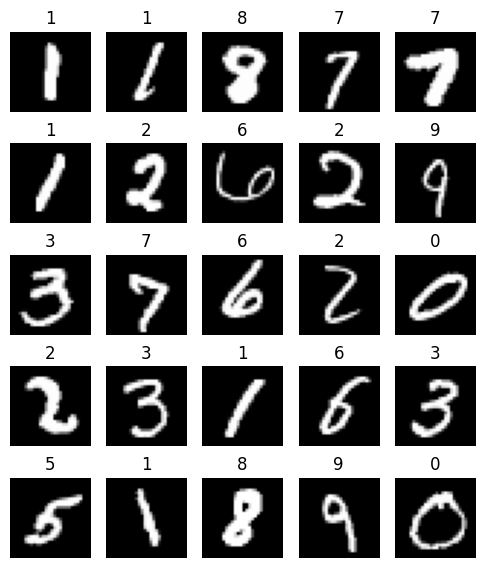

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Инициализация Xavier:

In [7]:
def init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()

    a = math.sqrt(6.0 / (weight.size(0) + weight.size(1)))
    weight.uniform_(-a, a)

In [8]:
def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [9]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

In [10]:
init_layer(layer_1)
init_layer(layer_2)

In [11]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [12]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [13]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty(self.linear.weight.shape).bernoulli_(1 - self.p)
        else:
            mask = torch.ones(self.linear.weight.shape) * (1 - self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [10]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Сравним сети с Dropout и с DropConnect. Обучим сеть с Dropout:

In [15]:
layers = [
    nn.Linear(196, 150),
    nn.ReLU(),
    Dropout(),
    nn.Linear(150, 50),
    nn.ReLU(),
    Dropout(),
    nn.Linear(50, 10)
]

In [16]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [17]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297989
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.309682
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.768953
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.888813
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.612562
Test Epoch: 0	Loss: 0.443063
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.527054
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.728768
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.512113
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.491150
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.452079
Test Epoch: 1	Loss: 0.346949
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.344024
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.437360
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.411374
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.229106
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.409633
Test Epoch: 2	Loss: 0.277418
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.315281
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.255896
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.275667
Train Epoch: 3 [38400/60000 (64%)

Обучим сеть с DropConnect:

In [18]:
layers = [
    DropConnect(196, 150),
    nn.ReLU(),
    DropConnect(150, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
]

In [19]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [20]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311105
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.943649
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.790515
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.638415
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.445982
Test Epoch: 0	Loss: 0.333945
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.471000
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.507793
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.458510
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.546099
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.344802
Test Epoch: 1	Loss: 0.202993
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.216446
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.418954
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.345017
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.118976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.179790
Test Epoch: 2	Loss: 0.140701
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.140774
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.202229
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.200887
Train Epoch: 3 [38400/60000 (64%)

Видим, что DropConnect дал лучший результат по лоссу на тесте, но худший результат по времени обучения

Реализуем Layer Normalization:

In [7]:
class LayerNormalization(nn.Module):
    def __init__(self):
        super(LayerNormalization, self).__init__()

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)

        output = (x - mean) / (std + 1e-5)
        return output

Сначала обучим модель без LN:

In [11]:
layers = [
    nn.Linear(196, 150),
    nn.ReLU(),
    nn.Linear(150, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
]

In [12]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [13]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.301291
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.480404
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.432026
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.334246
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.156652
Test Epoch: 0	Loss: 0.194087
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.124387
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.116840
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.183285
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.246171
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.233643
Test Epoch: 1	Loss: 0.122418
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.210973
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.082373
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.147663
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.092572
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.182936
Test Epoch: 2	Loss: 0.102581
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.170169
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.063942
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.166306
Train Epoch: 3 [38400/60000 (64%)

Теперь обучим модель с LN:

In [14]:
layers = [
    nn.Linear(196, 150),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(150, 50),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(50, 10)
]

In [15]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [16]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.355106
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.419344
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.235242
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.093932
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.089526
Test Epoch: 0	Loss: 0.121864
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.126951
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.140948
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.146110
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.091814
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.096021
Test Epoch: 1	Loss: 0.100051
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.042734
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.031798
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.092036
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.077507
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.063296
Test Epoch: 2	Loss: 0.085154
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.034776
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.039248
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.033083
Train Epoch: 3 [38400/60000 (64%)

Видим, что модель с LN и модель без LN дали сравнимые результаты